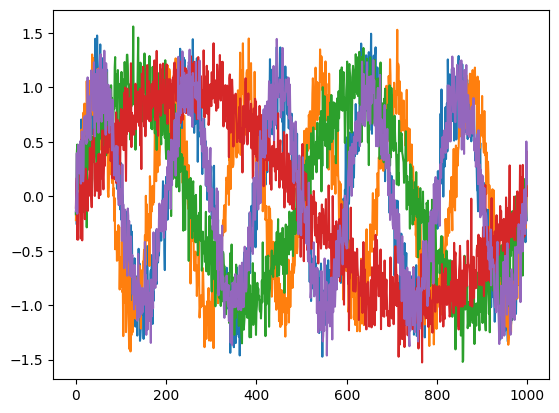

In [1]:
# Generate some time-series data that we will use for training RNNs
import torch
import matplotlib.pyplot as plt

# Set the random seed for reproducibility
torch.manual_seed(1)

# Generate the time-series data
# We make a bunch of different time-series consisting
# of different frequencies of sine waves plus additive noise
num_series = 100
num_timepoints = 1000
time = torch.arange(0, num_timepoints).float()
data = torch.zeros(num_series, num_timepoints)
# (Note, you could and totally should vectorize this)
for i in range(num_series):
    freq = torch.randint(1, 10, (1,))
    data[i] = torch.sin(2 * torch.pi * freq * time / num_timepoints) + torch.randn(num_timepoints) * 0.2
    
# Plot the first 5 time-series
plt.figure()
for i in range(5):
    plt.plot(time, data[i])


In [9]:
# Okay, now lets see if we can successfully predict the next timepoint in the time-series for the first sine wave
# We look at doing a linear regression here for different time lags
class LinearRegressor(torch.nn.Module):
    def __init__(self, total_history=5):
        super(LinearRegressor, self).__init__()
        self.linear = torch.nn.Linear(total_history, 1)
        
    def forward(self, x):
        return self.linear(x)
    
# Okay, now lets turn this into data that's easy to iterate over
# using torch datasets and torch dataloaders
# This is a useful utility class that we will reuse
from torch.utils.data import Dataset
class TimeSeriesDataset(Dataset):
    def __init__(self, data, total_history, prediction_horizon=1):
        self.data = data
        self.total_history = total_history
        self.prediction_horizon = prediction_horizon
        
    def __len__(self):
        # This tells pytorch how much data we have
        return len(self.data) - self.total_history - self.prediction_horizon
    
    def __getitem__(self, idx):
        # This actually returns the data
        # Note that here we are constructing the features by stacking
        # a bunch of states together
        return self.data[idx:idx+self.total_history], self.data[idx+self.total_history + self.prediction_horizon]

# Lets construct a train and a validation set for the first time-series
# what are the features? Well, they're some number of datapoints observed so far
# and the label is the next datapoint
# We're going to be lazy and just make the validation set the latter half of the data

def train_for_history(total_history=5, prediction_horizon=1):
    train_split = 0.8
    num_train = int(num_timepoints * train_split)
    train_data = data[0, :num_train]
    val_data = data[0, num_train:]

    train_dataset = TimeSeriesDataset(train_data, total_history, prediction_horizon)
    val_dataset = TimeSeriesDataset(val_data, total_history, prediction_horizon)

    # Okay, now we can use an object called a torch dataloader to iterate over the data
    train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
    # val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Okay, now lets train our model
    model = LinearRegressor(total_history)
    loss = torch.nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
    num_epochs = 30
    train_losses = []
    val_losses = []
    for epoch in range(num_epochs):
        avg_train_loss = 0
        for i, (x, y) in enumerate(train_dataloader):
            optimizer.zero_grad()
            y_pred = model(x)
            l = loss(y_pred.squeeze(), y)
            l.backward()
            optimizer.step()
            avg_train_loss += l.item()
        train_losses.append(avg_train_loss)
        
        avg_val_loss = 0
        # for i, (x, y) in enumerate(val_dataloader):
        #     y_pred = model(x)
        #     l = loss(y_pred.squeeze(), y)
        #     avg_val_loss += l.item()
        # val_losses.append(avg_val_loss)
        # print(f"Epoch {epoch} Train loss: {train_losses[-1]} Val loss: {val_losses[-1]}")

    # Now lets plot the training and validation losses
    plt.figure()
    plt.plot(train_losses, label='Train loss')
    # plt.plot(val_losses, label='Val loss')
    plt.legend()

    # Now lets plot our predictions
    model.eval()
    with torch.no_grad():
        predictions = []
        for i in range(train_data.shape[0] - total_history):
            x = train_data[i:i+total_history]
            y = model(x)
            predictions.append(y.item())

    plt.figure()
    plt.plot(train_data[total_history:], label='True data')
    plt.plot(predictions, label='Predictions')
    plt.legend()
    
    return model 


LinearRegressor(
  (linear): Linear(in_features=64, out_features=1, bias=True)
)

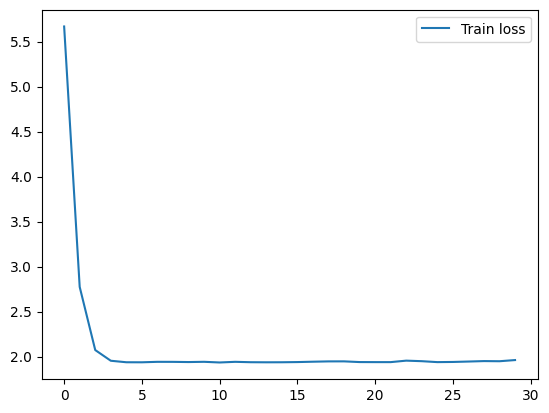

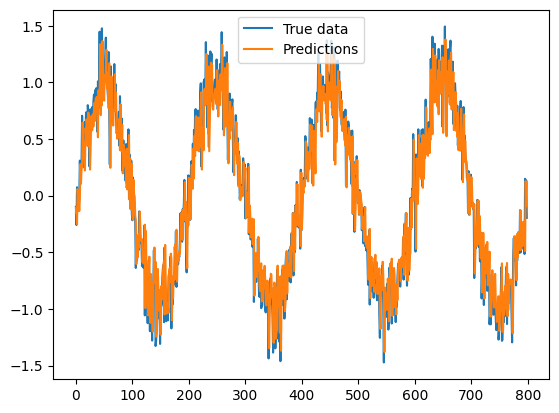

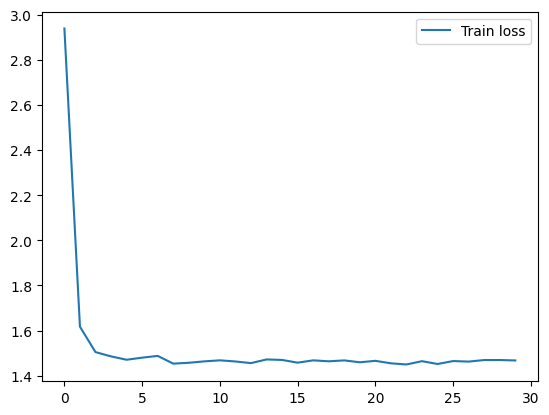

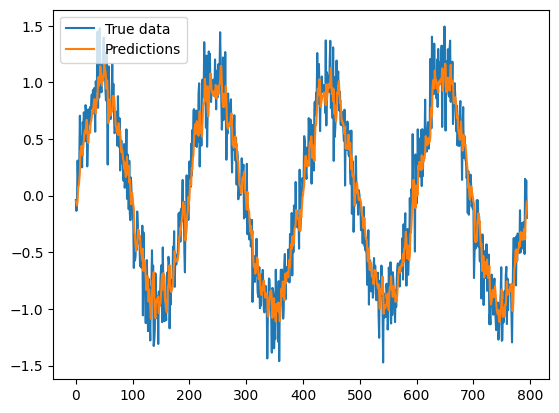

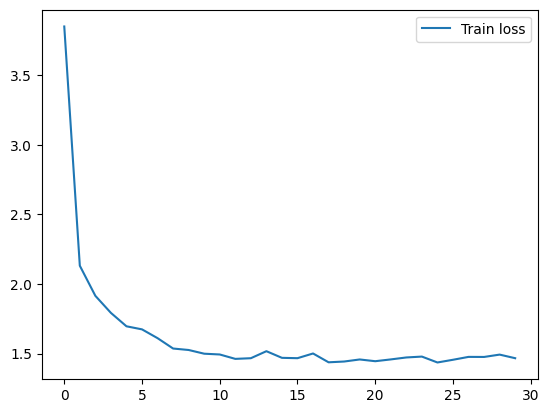

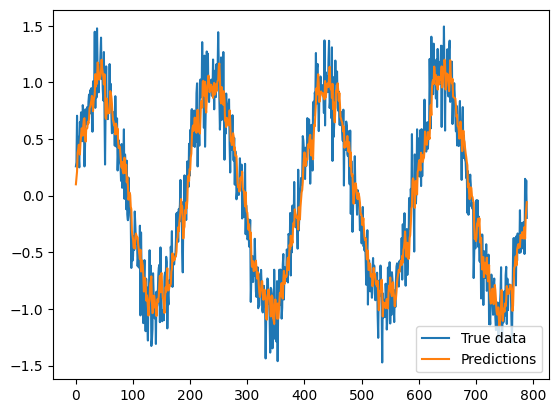

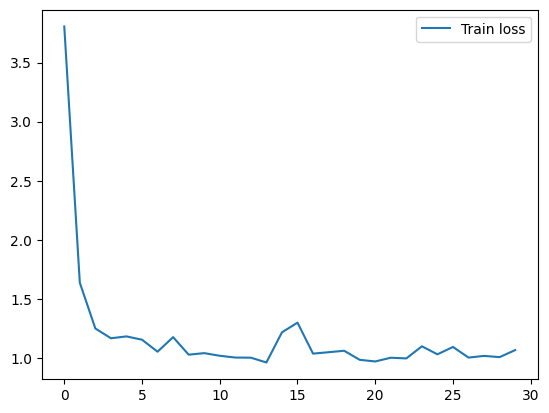

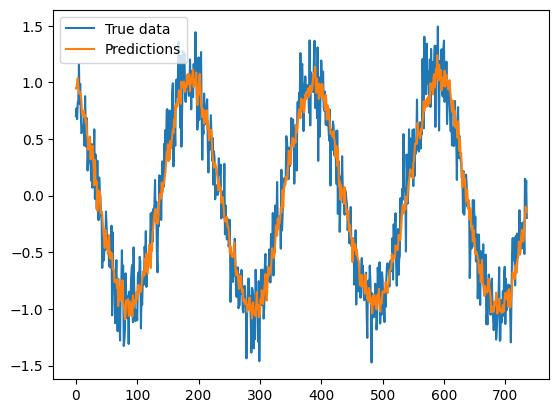

In [10]:
train_for_history(1)
train_for_history(5)
model = train_for_history(10)
train_for_history(64)

LinearRegressor(
  (linear): Linear(in_features=5, out_features=1, bias=True)
)

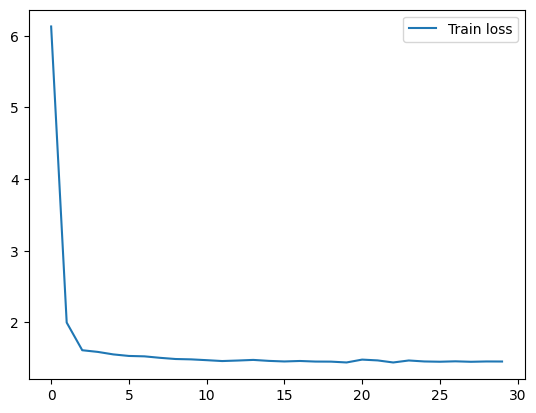

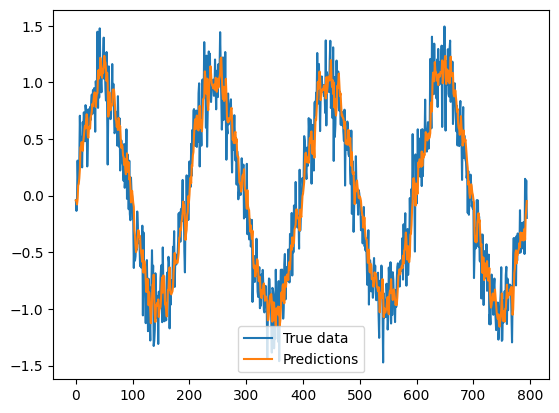

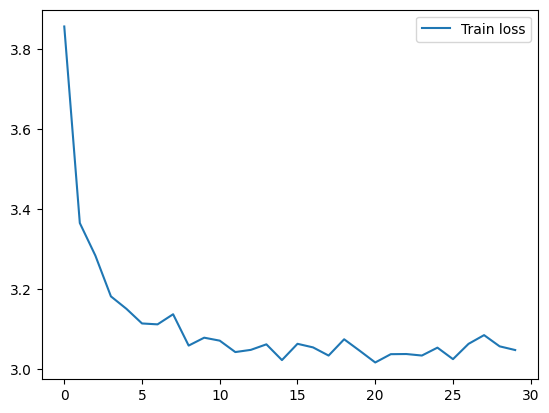

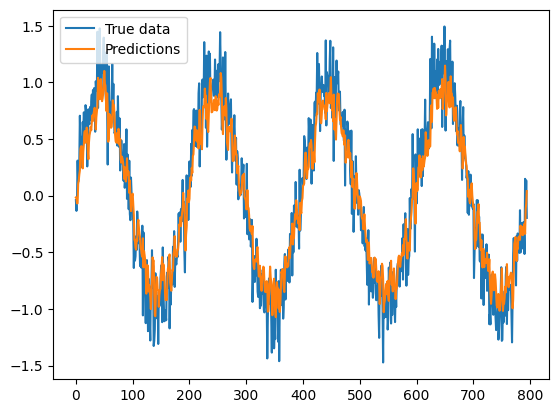

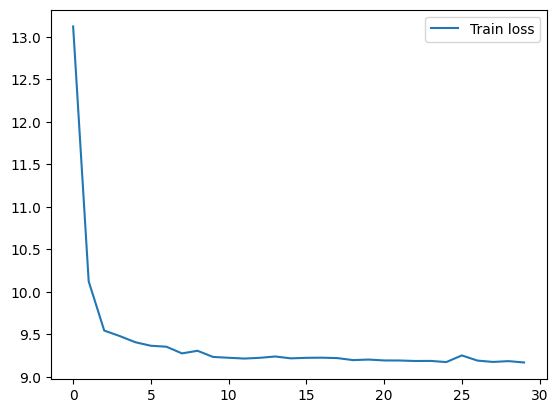

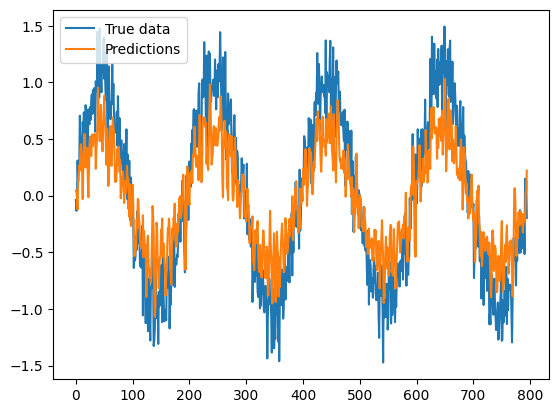

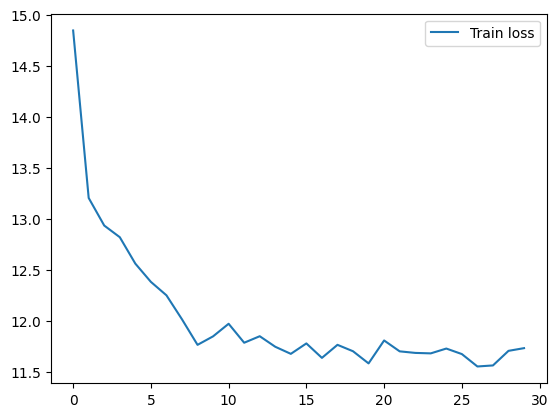

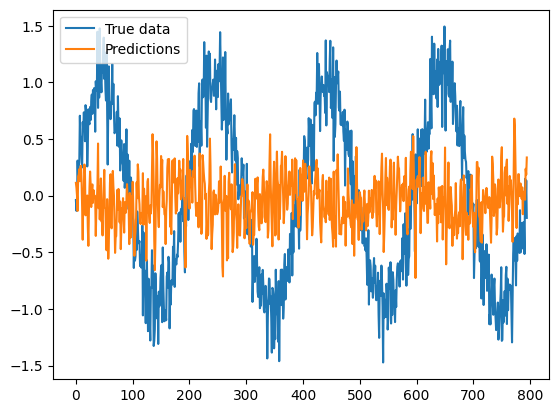

In [12]:
# now lets do the same thing for longer horizon predictions
train_for_history(5, 1)
train_for_history(5, 10)
train_for_history(5, 30)
train_for_history(5, 50)

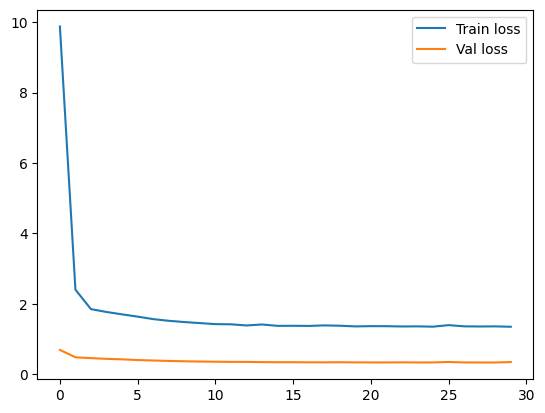

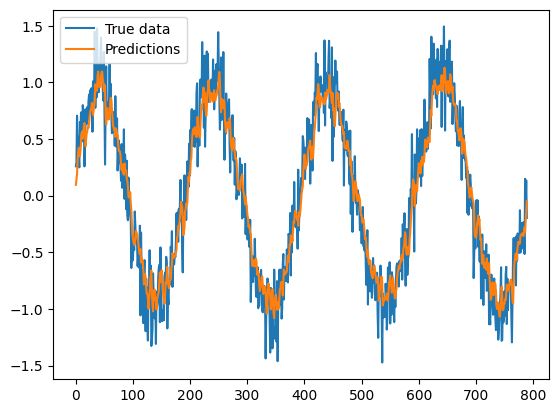

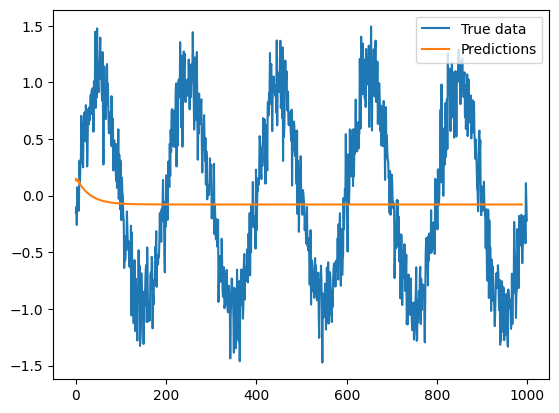

In [4]:
# At this point you might very well and reasonably say, why deep learning? Seems like we can fit this task pretty fine. 
# Now lets ask a slightly trickier question; what happens if we try to predict the next timepoint in the time-series and we sequentially keep using the previous prediction as the next input?

history_len = 10
model = train_for_history(history_len)
train_dataset = TimeSeriesDataset(data[0], history_len)
# Lets grab the first datapoint and iterate from there
x, y = train_dataset[0]
predictions = []
for i in range(1, num_timepoints - history_len):
    x = torch.cat((x[1:], y.unsqueeze(0)))
    y = model(x).squeeze()
    predictions.append(y.item())

plt.figure()
plt.plot(data[0], label='True data')
plt.plot(predictions, label='Predictions')
plt.legend()


## Accumulating error
So what's wrong? The issue is that we are trying to chain together a series of predictions that are accurate for each individual point but always with a little bit of error. When we chain these together, the error compounds and we end up with a prediction that is very far from the true value. Imagine that at the first step we have some error $\epsilon_1$. Lets denote our time series as $x$ and use $x_t$ to denote the t-th element. Lets call the stacked feature we have been making $f_t$ to represent the t-th feature and use $\phi_{t,i}$ to denote the i-th element of the t-th feature. Finally, we will call our model $f$ as in $$y = f(\phi)$$ Then our first feature is $$\phi_0 = \left[x_0, x_1, x_2, \dots, x_T\right]$$ where $T$ is the time window that we are using for features. Calling our i-th prediction as $y_i$ our next feature will then be $$f_1 = \left[x_1, x_2, \dots, x_T, y_0\right]$$ where $y_0$ is our prediction of $x_{T+1}$. The problem is that $y_0$ is not the same as $x_{T+1}$ and so we have some error $\epsilon_1 = y_0 - x_{T+1}$. This error will compound as we make more predictions. Our next prediction will be $y_1 = f(\phi_1)$ and our next feature will be $\phi_2 = {x_2, \dots, x_T, y_0, y_1}$ where $y_1$ is our prediction of $x_{T+2}$. The error in this prediction will be $\epsilon_2 = y_1 - x_{T+2}$. This error will compound with the previous error and so on.

So, gradually, due to accumulating error, our features look less and less like the data and so our model will perform worse and worse. It simply has not seen features that look like this at all. 

## Autoregressive models
